In [1]:
from datasets import load_dataset,load_from_disk, Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import torch
import torchmetrics
import os
import tempfile
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data.datapipes.iter import Shuffler


In [2]:
# Set cache directories to /tmp (which has space)
os.environ["HF_DATASETS_CACHE"] = "/tmp/hf_cache"
os.environ["TRANSFORMERS_CACHE"] = "/tmp/hf_cache"
os.environ["XDG_CACHE_HOME"] = "/tmp/hf_cache"
tempfile.tempdir = "/tmp"

In [3]:
# load in dataset via streaming and set seed
dataset = load_dataset("1aurent/BACH", split='train')
seed = 42

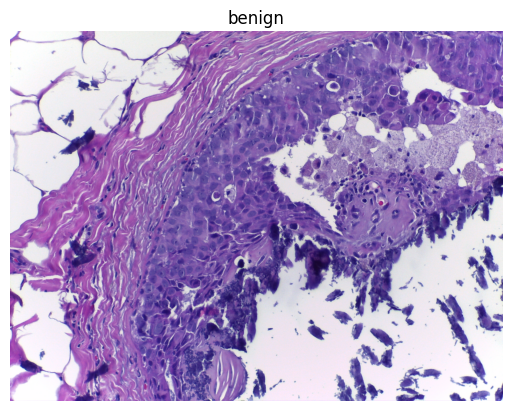

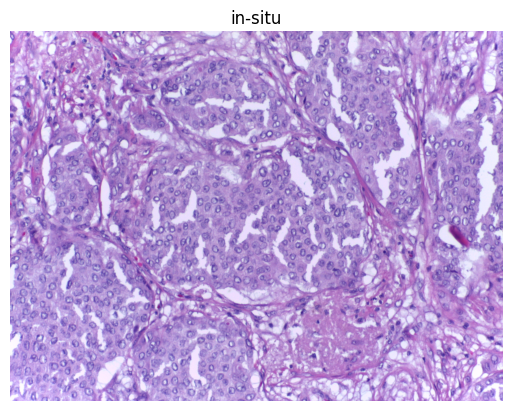

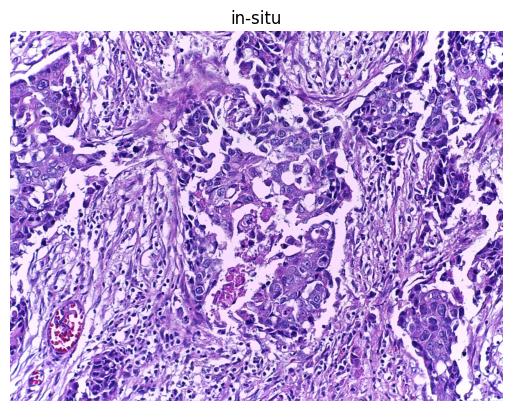

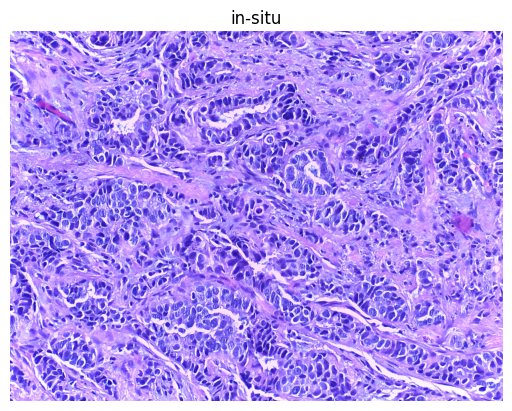

In [4]:
diagnosis = ["normal","benign","in-situ","invasive"]

for i in range(4):
    j = random.randint(0,400)
    image = dataset[j]["image"]
    plt.imshow(image)
    plt.title(diagnosis[dataset[j]["label"]])
    plt.axis("off")
    plt.show()

In [5]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 400
})

In [6]:
train_dataset, val_dataset = dataset.train_test_split(test_size=0.2).values()
print(len(train_dataset), len(val_dataset))

320 80


In [7]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        if self.transform:
            image = self.transform(image)
        
        return image, label

In [8]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1,
        saturation=0.1,
        hue=0.05            
    ),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
train_data = CustomDataset(train_dataset, transform=transform)
val_data = CustomDataset(val_dataset, transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)

# Check the DataLoader
for i, (images, labels) in enumerate(train_loader):
    print(f"Batch {i+1} - Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    break

Batch 1 - Image batch shape: torch.Size([16, 3, 224, 224])
Label batch shape: torch.Size([16])


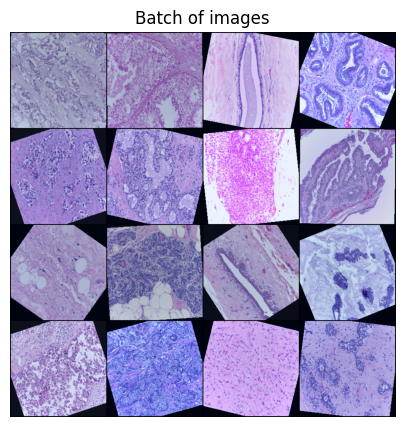

In [10]:
images, labels = next(iter(val_loader))

grid = make_grid(images, nrow=4, normalize=True)

plt.figure(figsize=(10, 5))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis('off')
plt.title("Batch of images")
plt.show()

In [11]:
# Hyper Parameters
num_classes = 4
learning_rate = 1e-4 #LAST LAYER
num_epochs = 30
batch_size = 16
dropout_rate = 0.4
weight_decay= 1e-2

In [12]:



# ResNet 18

In [13]:
# Load in pretrained model
resNet_model = models.resnet18(pretrained=True)
resNet_model.fc = nn.Sequential(
    nn.Dropout(dropout_rate),
    nn.Linear(resNet_model.fc.in_features, num_classes)
)

#Freeze all layers minus last block + custom output layer
for param in resNet_model.parameters():
    param.requires_grad = False
    
for param in resNet_model.layer4.parameters():
    param.requires_grad = True 
    
for param in resNet_model.fc.parameters():
    param.requires_grad = True

/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /tmp/hf_cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|███████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 243MB/s]


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
resNet_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': resNet_model.layer4.parameters(), 'lr':1e-4},
    {'params': resNet_model.fc.parameters(), 'lr':learning_rate}], 
    weight_decay=weight_decay)

cuda


In [ ]:
train_losses = []  
val_losses = []  
train_accuracies = []  
val_accuracies = []  
   
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Training + Validating Network
for epoch in range(num_epochs):
    batch_num = 0
    
    resNet_model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    for batch in train_loader:
        
        #load data to GPU
        images, labels = batch
        images = images.to(device)
        labels = labels.to(torch.int64).to(device)

        
        #forward
        predictions = resNet_model(images)
        loss = criterion(predictions, labels)
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #training accuracy
        predicted_classes = predictions.argmax(dim=1)
        accuracy = (predicted_classes == labels).float().mean().item()
        train_accuracy += accuracy
        train_loss += loss.item()
        
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    avg_train_accuracy = train_accuracy / len(train_loader)
    train_accuracies.append(avg_train_accuracy)
    
    resNet_model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad(): 
        for batch in val_loader:
            
            #load data to GPU
            images, labels = batch
            images = images.to(device)
            labels = labels.to(torch.int64).to(device)
            
            # forward
            predictions = resNet_model(images)
            loss = criterion(predictions, labels)
            
            # Validation accuracy
            predicted_classes = predictions.argmax(dim=1)
            accuracy = (predicted_classes == labels).float().mean().item()
            val_accuracy += accuracy
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    avg_val_accuracy = val_accuracy / len(val_loader)
    val_accuracies.append(avg_val_accuracy)
    
    print(f"Epoch {epoch+1}")
    print(f"Training - Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_accuracy:.4f}")
    print(f"Validation - Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_accuracy:.4f}")
    for param_group in optimizer.param_groups:
        print(f"lr: {param_group['lr']}")
    
    scheduler.step(avg_val_loss)

In [ ]:
# Plotting the Loss Graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='red', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
predicted_classes = predictions.argmax(dim=1)

print("Predictions:", predicted_classes[:10])
print("Labels:", labels[:10])

In [ ]:



# mobileNet

In [ ]:
# Load in pretrained model
pt_model_2 = models.mobilenet_v2(pretrained=True)
pt_model_2.classifier[1] = nn.Sequential(
    nn.Dropout(dropout_rate),
    nn.Linear(pt_model_2.classifier[1].in_features, num_classes)
)


# Freeze all layers minus last block + custom output layer
for param in pt_model_2.parameters():
    param.requires_grad = False
    
for param in pt_model_2.features[-1:].parameters():
    param.requires_grad = True
    
for param in pt_model_2.classifier[1].parameters():    
    param.requires_grad = True

In [ ]:
# Load model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pt_model_2.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, pt_model_2.parameters()),
    lr=learning_rate,
    weight_decay=1e-4
)

In [ ]:
train_losses = []  
val_losses = []  
train_accuracies = []  
val_accuracies = []  
   
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Training + Validating Network
for epoch in range(num_epochs):
    batch_num = 0
    
    pt_model_2.train()
    train_loss = 0.0
    train_accuracy = 0.0
    for batch in train_loader:
        
        #load data to GPU
        images, labels = batch
        images = images.to(device)
        labels = labels.to(torch.int64).to(device)

        
        #forward
        predictions = pt_model_2(images)
        loss = criterion(predictions, labels)
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #training accuracy
        predicted_classes = predictions.argmax(dim=1)
        accuracy = (predicted_classes == labels).float().mean().item()
        train_accuracy += accuracy
        train_loss += loss.item()
        
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    avg_train_accuracy = train_accuracy / len(train_loader)
    train_accuracies.append(avg_train_accuracy)
    
    pt_model_2.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad(): 
        for batch in val_loader:
            
            #load data to GPU
            images, labels = batch
            images = images.to(device)
            labels = labels.to(torch.int64).to(device)
            
            # forward
            predictions = pt_model_2(images)
            loss = criterion(predictions, labels)
            
            # Validation accuracy
            predicted_classes = predictions.argmax(dim=1)
            accuracy = (predicted_classes == labels).float().mean().item()
            val_accuracy += accuracy
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    avg_val_accuracy = val_accuracy / len(val_loader)
    val_accuracies.append(avg_val_accuracy)
    
    print(f"Epoch {epoch+1}")
    print(f"Training - Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_accuracy:.4f}")
    print(f"Validation - Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_accuracy:.4f}")
    
    for param_group in optimizer.param_groups:
        print(f"lr: {param_group['lr']}")
    
    scheduler.step(avg_val_loss)

In [ ]:
# Plotting the Loss Graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='red', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:



# ResNet 18

# Load in pretrained model
resNet_model = models.resnet18(pretrained=True)
resNet_model.fc = nn.Sequential(
    nn.Dropout(dropout_rate),
    nn.Linear(resNet_model.fc.in_features, num_classes)
)

#Freeze all layers minus last block + custom output layer
for param in resNet_model.parameters():
    param.requires_grad = False
    
for param in resNet_model.layer4.parameters():
    param.requires_grad = True 
    
for param in resNet_model.fc.parameters():
    param.requires_grad = True

# Setting to training mode
resNet_model.train()
_ = resNet_model.train()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
resNet_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': resNet_model.layer4.parameters(), 'lr':1e-4},
    {'params': resNet_model.fc.parameters(), 'lr':learning_rate}], 
    weight_decay=weight_decay)

train_losses = []  
val_losses = []  
train_accuracies = []  
val_accuracies = []  
   
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training + Validating Network
for epoch in range(num_epochs):
    batch_num = 0
    
    resNet_model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    for batch in train_loader:
        
        #load data to GPU
        images, labels = batch
        images = images.to(device)
        labels = labels.to(torch.int64).to(device)

        
        #forward
        predictions = resNet_model(images)
        loss = criterion(predictions, labels)
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #training accuracy
        predicted_classes = predictions.argmax(dim=1)
        accuracy = (predicted_classes == labels).float().mean().item()
        train_accuracy += accuracy
        train_loss += loss.item()
        
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    avg_train_accuracy = train_accuracy / len(train_loader)
    train_accuracies.append(avg_train_accuracy)
    
    resNet_model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad(): 
        for batch in val_loader:
            
            #load data to GPU
            images, labels = batch
            images = images.to(device)
            labels = labels.to(torch.int64).to(device)
            
            # forward
            predictions = resNet_model(images)
            loss = criterion(predictions, labels)
            
            # Validation accuracy
            predicted_classes = predictions.argmax(dim=1)
            accuracy = (predicted_classes == labels).float().mean().item()
            val_accuracy += accuracy
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    avg_val_accuracy = val_accuracy / len(val_loader)
    val_accuracies.append(avg_val_accuracy)
    
    print(f"Epoch {epoch+1}")
    print(f"Training - Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_accuracy:.4f}")
    print(f"Validation - Loss: {avg_val_loss:.4f}, Accuracy: {avg_val_accuracy:.4f}")
    for param_group in optimizer.param_groups:
        print(f"lr: {param_group['lr']}")
    
    scheduler.step(avg_val_loss)

# Plotting the Loss Graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='red', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.ylim(0, 1)
plt.tight_layout()
plt.show()

predicted_classes = predictions.argmax(dim=1)

print("Predictions:", predicted_classes[:10])
print("Labels:", labels[:10])